https://github.com/ma3ti/Swin-transformer-ChestXray/tree/main/finetune

# Swin transformer 
## Computer Vision project 24/25

In [28]:
import os
import sys
import time
import re
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
os.environ['LOCAL_RANK'] = '0'
os.environ['WORLD_SIZE'] = '1'
os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '12345'

sys.path.append(os.path.abspath('..'))

try:
    from config import get_config
    from models import build_model
except ImportError:
    print("Error: Could not import 'config' or 'models'. Make sure you are in the Swin-Transformer project root or correct the path.")

In [30]:
# Check for acceleration (MPS for Mac, CUDA for NVIDIA, or CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using NVIDIA GPU ({torch.cuda.get_device_name(0)})")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Metal acceleration (MPS)")
else:
    device = torch.device("cpu")
    print("Using CPU")

Using Apple Metal acceleration (MPS)


In [ ]:
class Args:
    cfg = ""  
    opts = ["MODEL.NUM_CLASSES", "2"]
    batch_size = 32
    data_path = ""  
    zip = False
    cache_mode = "part"
    pretrained = ""
    resume = ""
    accumulation_steps = 1
    use_checkpoint = False
    amp_opt_level = ""
    output = "output"
    tag = "default"
    eval = True
    throughput = False
    enable_amp = False
    fused_window_process = False
    fused_layernorm = False
    optim = "adamw"
    local_rank = 0


swin7_log_path = 'results/swin/log_rank0.txt' 
swin14_log_path = 'results/swin14/log_rank0.txt'
vit_log_path = 'results/vit/log_rank0.txt'

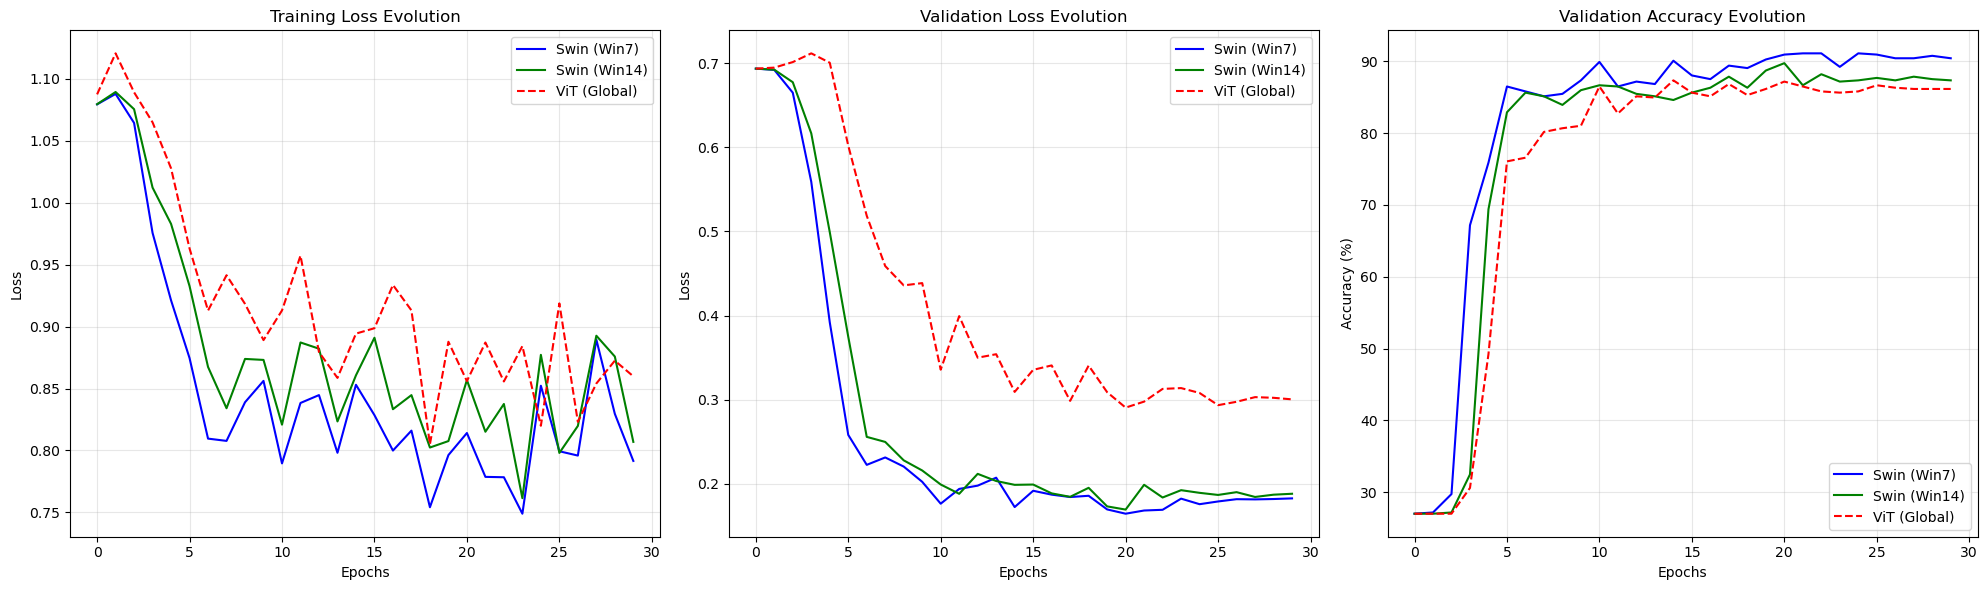

Plot saved as 'swin_vs_vit_training_history.png'


In [ ]:
def parse_training_log(file_path):
    """Legge il file di log ed estrae le metriche per epoca."""
    
    if not os.path.exists(file_path):
        print(f"File non trovato: {file_path}")
        return None

    data = {
        'epochs': [],
        'train_loss': [],
        'val_loss': [],
        'val_acc': []
    }
    
    train_pattern = re.compile(r'Train: \[(\d+)/\d+\]\[\d+/\d+\].*loss (\d+\.\d+)')
    test_pattern = re.compile(r'Test: \[(\d+)/\d+\].*Loss (\d+\.\d+)')
    acc_pattern = re.compile(r'\* Acc@1 (\d+\.\d+)')

    current_epoch_train_losses = []
    temp_val_losses = []
    
    with open(file_path, 'r') as f:
        lines = f.readlines()

    current_epoch = -1
    
    for line in lines:
        match_train = train_pattern.search(line)
        if match_train:
            epoch = int(match_train.group(1))
            loss = float(match_train.group(2))
            
            if epoch != current_epoch:
                if current_epoch_train_losses:
                    data['train_loss'].append(np.mean(current_epoch_train_losses))
                    data['epochs'].append(current_epoch)
                current_epoch = epoch
                current_epoch_train_losses = []
            
            current_epoch_train_losses.append(loss)

        match_test = test_pattern.search(line)
        if match_test:
            loss = float(match_test.group(2))
            temp_val_losses.append(loss)

        match_acc = acc_pattern.search(line)
        if match_acc:
            acc = float(match_acc.group(1))
            
            data['val_acc'].append(acc)
            
            if temp_val_losses:
                data['val_loss'].append(np.mean(temp_val_losses))
                temp_val_losses = []
            else:
                data['val_loss'].append(0.0) 

    if current_epoch_train_losses and len(data['train_loss']) < len(data['epochs']) + 1:
        data['train_loss'].append(np.mean(current_epoch_train_losses))
        data['epochs'].append(current_epoch)

    min_len = min(len(data['epochs']), len(data['train_loss']), len(data['val_acc']))
    data['epochs'] = data['epochs'][:min_len]
    data['train_loss'] = data['train_loss'][:min_len]
    data['val_loss'] = data['val_loss'][:min_len]
    data['val_acc'] = data['val_acc'][:min_len]
    
    return data



swin7_data = parse_training_log(swin7_log_path)
swin14_data = parse_training_log(swin14_log_path)
vit_data = parse_training_log(vit_log_path)

if swin7_data is None and swin14_data is None and vit_data is None:
    print("No log files found.")
else:
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    axes[0].set_title("Training Loss Evolution")
    if swin7_data:
        axes[0].plot(swin7_data['epochs'], swin7_data['train_loss'], 'b-', label='Swin (Win7)')
    if swin14_data:
        axes[0].plot(swin14_data['epochs'], swin14_data['train_loss'], 'g-', label='Swin (Win14)')
    if vit_data:
        axes[0].plot(vit_data['epochs'], vit_data['train_loss'], 'r--', label='ViT (Global)')
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()

    axes[1].set_title("Validation Loss Evolution")
    if swin7_data:
        axes[1].plot(swin7_data['epochs'], swin7_data['val_loss'], 'b-', label='Swin (Win7)')
    if swin14_data:
        axes[1].plot(swin14_data['epochs'], swin14_data['val_loss'], 'g-', label='Swin (Win14)')
    if vit_data:
        axes[1].plot(vit_data['epochs'], vit_data['val_loss'], 'r--', label='ViT (Global)')
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Loss")
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()

    axes[2].set_title("Validation Accuracy Evolution")
    if swin7_data:
        axes[2].plot(swin7_data['epochs'], swin7_data['val_acc'], 'b-', label='Swin (Win7)')
    if swin14_data:
        axes[2].plot(swin14_data['epochs'], swin14_data['val_acc'], 'g-', label='Swin (Win14)')
    if vit_data:
        axes[2].plot(vit_data['epochs'], vit_data['val_acc'], 'r-', label='ViT (Global)')
    axes[2].set_xlabel("Epochs")
    axes[2].set_ylabel("Accuracy (%)")
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()

    plt.tight_layout()
    plt.savefig("swin_vs_vit_training_history.png")
    plt.show()
    print("Plot saved as 'swin_vs_vit_training_history.png'")


In [ ]:
def evaluate_model(model_name, config_path, checkpoint_path, test_loader, classes):
    """
    Evaluate a trained model on the test dataset. 
    Args:
        model_name (str): Name of the model (for logging purposes).
        config_path (str): Path to the model configuration file.
        checkpoint_path (str): Path to the model checkpoint file.
        test_loader (DataLoader): DataLoader for the test dataset.
        classes (list): List of class names.
    Returns:
        dict: Dictionary containing accuracy, sensitivity, specificity, confusion matrix, predictions, and targets. 
    """

    print(f"\n{'='*20} EVALUATING: {model_name} {'='*20}")
    
    # 1. Setup Config & Model
    args = Args()
    args.cfg = config_path # Impostiamo il config specifico (Swin o ViT)
    
    # Verifica esistenza file
    if not os.path.exists(config_path):
        print(f"Config not found: {config_path}")
        return None
    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint not found: {checkpoint_path}")
        return None

    config = get_config(args)
    print(f"Building model (Window Size: {config.MODEL.SWIN.WINDOW_SIZE})...")
    model = build_model(config)

    # 2. Load Weights
    print(f"Loading weights from: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location='cpu')
    state_dict = checkpoint['model'] if 'model' in checkpoint else checkpoint
    msg = model.load_state_dict(state_dict, strict=False)
    # print(f"Load msg: {msg}")

    model.to(device)
    model.eval()

    # 3. Inference Loop
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for images, targets in tqdm(test_loader, desc=f"Testing {model_name}"):
            images = images.to(device)
            targets = targets.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    preds_np = np.array(all_preds)
    targets_np = np.array(all_targets)

    # 4. Metrics
    cm = confusion_matrix(targets_np, preds_np)
    tn, fp, fn, tp = cm.ravel()
    
    metrics = {
        'accuracy': (tp + tn) / (tp + tn + fp + fn),
        'sensitivity': tp / (tp + fn) if (tp + fn) > 0 else 0,
        'specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
        'cm': cm,
        'preds': preds_np,
        'targets': targets_np
    }
    
    print(f"Accuracy: {metrics['accuracy']:.2%}")
    return metrics

Loading Test Data from ../dataset/chest_xray_new/test...

==================== EVALUATING: Swin (Window 7) ====================
=> merge config from ../configs/swin/chest_xray_finetune.yaml
Building model (Window Size: 7)...
Loading weights from: results/swin/swin7.pth


/var/folders/c4/m_6w9kxs5kj6jyfn6b9_dsbr0000gn/T/ipykernel_40119/476988980.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_

Accuracy: 89.78%

==================== EVALUATING: Swin (Window 14) ====================
=> merge config from ../configs/swin/chest_xray_finetune14.yaml
Building model (Window Size: 14)...
Loading weights from: results/swin14/swin14.pth


/var/folders/c4/m_6w9kxs5kj6jyfn6b9_dsbr0000gn/T/ipykernel_40119/476988980.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_

Accuracy: 88.07%

==================== EVALUATING: ViT-Sim (Window 56) ====================
=> merge config from ../configs/swin/chest_xray_vit.yaml
Building model (Window Size: 56)...
Loading weights from: results/vit/vit.pth


/var/folders/c4/m_6w9kxs5kj6jyfn6b9_dsbr0000gn/T/ipykernel_40119/476988980.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_

Accuracy: 86.03%


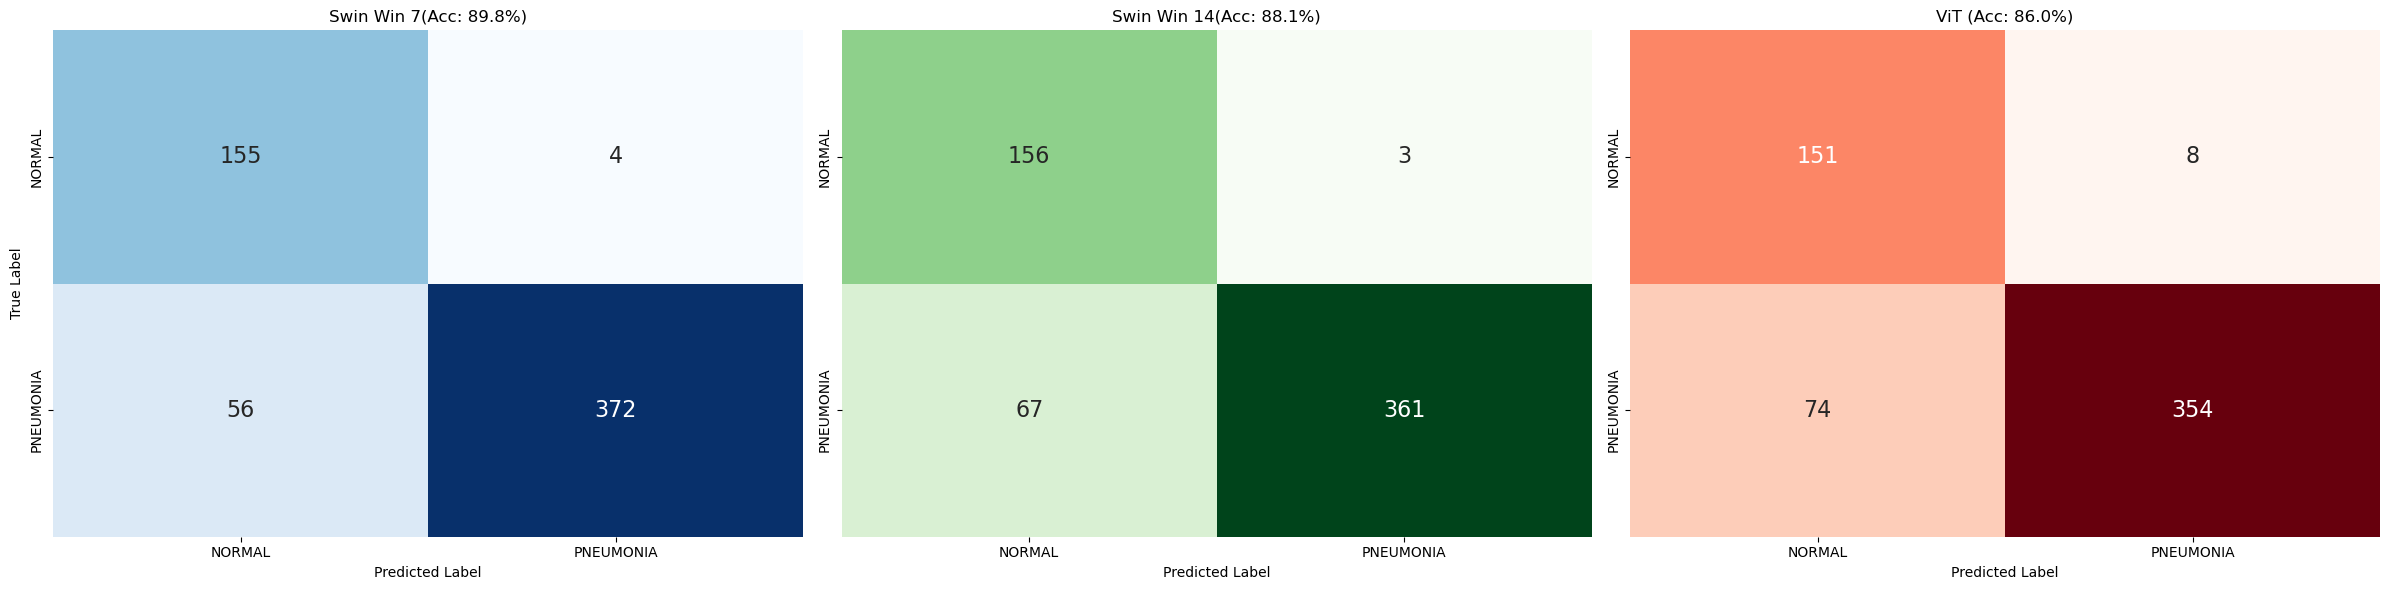

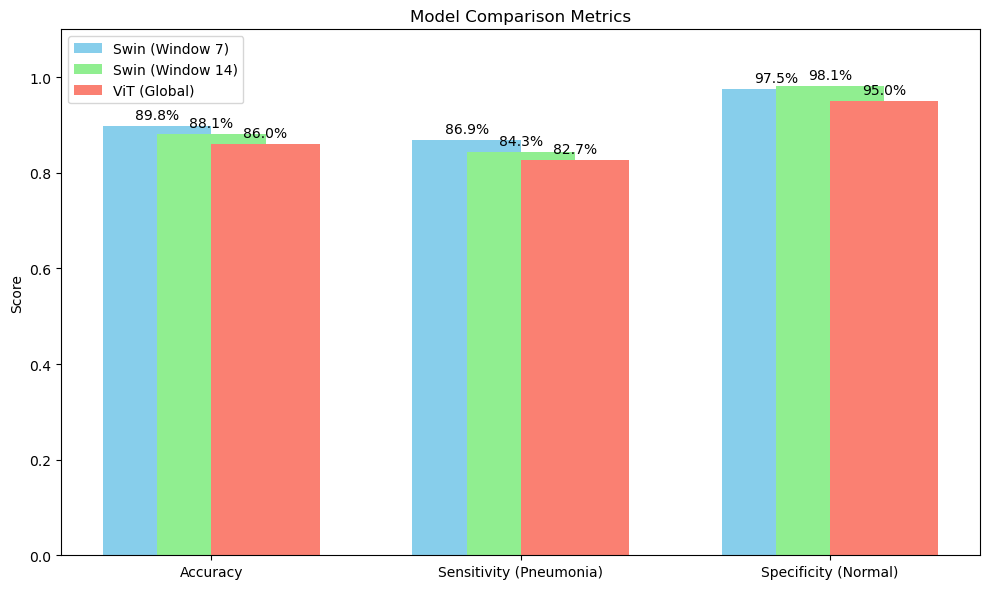

In [34]:
def main():
    test_dir = "../dataset/chest_xray_new/test"    
    swin7_cfg = "../configs/swin/chest_xray_finetune.yaml"
    swin7_ckpt = "results/swin/swin7.pth"
    swin14_cfg = "../configs/swin/chest_xray_finetune14.yaml"
    swin14_ckpt = "results/swin14/swin14.pth"
    vit_cfg = "../configs/swin/chest_xray_vit.yaml"
    vit_ckpt = "results/vit/vit.pth"
    
    print(f"Loading Test Data from {test_dir}...")
    test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transforms)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
    classes = test_dataset.classes

    results_swin7 = evaluate_model("Swin (Window 7)", swin7_cfg, swin7_ckpt, test_loader, classes)
    results_swin14 = evaluate_model("Swin (Window 14)", swin14_cfg, swin14_ckpt, test_loader, classes)
    results_vit = evaluate_model("ViT-Sim (Window 56)", vit_cfg, vit_ckpt, test_loader, classes)

    if results_swin7 is None or results_swin14 is None or results_vit is None:
        print("Impossible to proceed with comparison: missing files.")
        return


    fig, axes = plt.subplots(1, 3, figsize=(24, 6))
    
    sns.heatmap(results_swin7['cm'], annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0],
                xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})
    axes[0].set_title(f"Swin Win 7(Acc: {results_swin7['accuracy']:.1%})")
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    sns.heatmap(results_swin14['cm'], annot=True, fmt='d', cmap='Greens', cbar=False, ax=axes[1],
                xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})
    axes[1].set_title(f"Swin Win 14(Acc: {results_swin14['accuracy']:.1%})")
    axes[1].set_xlabel('Predicted Label')

    sns.heatmap(results_vit['cm'], annot=True, fmt='d', cmap='Reds', cbar=False, ax=axes[2],
                xticklabels=classes, yticklabels=classes, annot_kws={"size": 16})
    axes[2].set_title(f"ViT (Acc: {results_vit['accuracy']:.1%})")
    axes[2].set_xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


    labels = ['Accuracy', 'Sensitivity (Pneumonia)', 'Specificity (Normal)']
    
    swin7_vals = [results_swin7['accuracy'], results_swin7['sensitivity'], results_swin7['specificity']]
    swin14_vals = [results_swin14['accuracy'], results_swin14['sensitivity'], results_swin14['specificity']]
    vit_vals = [results_vit['accuracy'], results_vit['sensitivity'], results_vit['specificity']]

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, swin7_vals, width, label='Swin (Window 7)', color='skyblue')
    rects2 = ax.bar(x, swin14_vals, width, label='Swin (Window 14)', color='lightgreen')
    rects3 = ax.bar(x + width/2, vit_vals, width, label='ViT (Global)', color='salmon')

    ax.set_ylabel('Score')
    ax.set_title('Model Comparison Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.set_ylim(0, 1.1) 

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.1%}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3), 
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

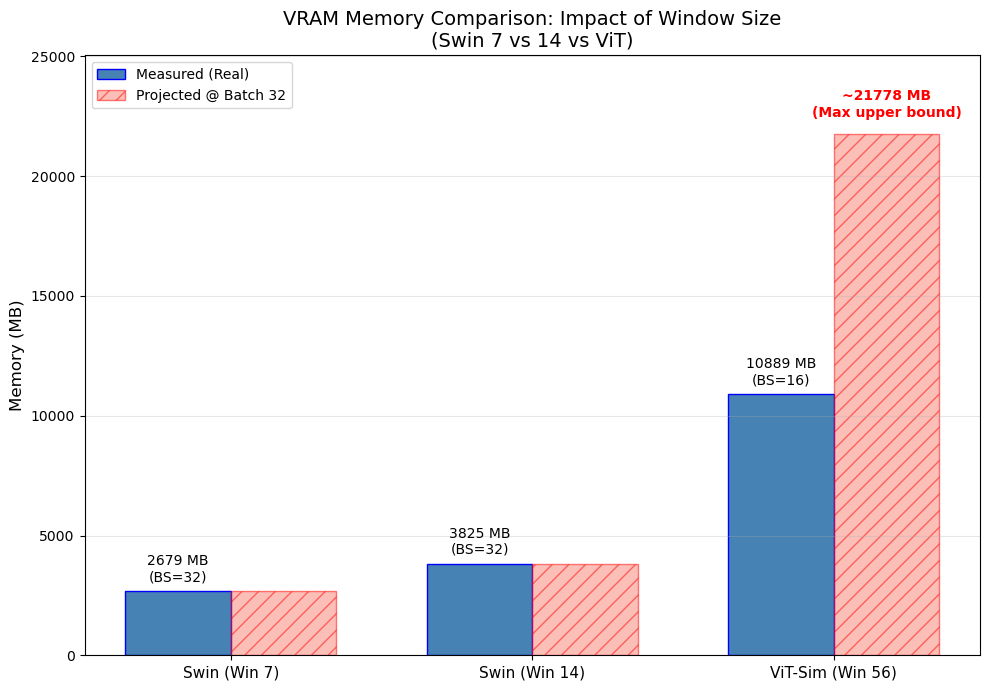

In [ ]:
models = ['Swin (Win 7)', 'Swin (Win 14)', 'ViT-Sim (Win 56)']
raw_memory = [2679, 3825, 10889]
batch_sizes = [32, 32, 16]           

normalized_memory = [
    2679,  
    3825, 
    10889 * (32/16) 
]

# --- CREAZIONE GRAFICO ---
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 7))

rects1 = ax.bar(x - width/2, raw_memory, width, label='Measured (Real)',
                color=['#4682b4', '#4682b4', '#4682b4'], edgecolor='blue') 

rects2 = ax.bar(x + width/2, normalized_memory, width, label='Projected @ Batch 32', 
                color='salmon', alpha=0.5, hatch='//', edgecolor='red')

ax.set_ylabel('Memory (MB)', fontsize=12)
ax.set_title('VRAM Memory Comparison: Impact of Window Size\n(Swin 7 vs 14 vs ViT)', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=11)
ax.legend(loc='upper left')

# Annotazioni
def autolabel(rects, b_sizes=None, is_projected=False):
    """
    Attaches a text label above each bar in *rects*, displaying its height.
    If is_projected is True, it indicates that the bar represents projected memory usage.
    Args:
        rects: Bars to annotate.
        b_sizes: Corresponding batch sizes for raw memory bars.
        is_projected (bool): Flag indicating if the bars are projected memory usage.
    """

    for i, rect in enumerate(rects):
        height = rect.get_height()
        
        if is_projected:
            if i == 2:
                label = f"~{int(height)} MB\n(Max upper bound)"
                color = 'red'
                weight = 'bold'
                y_offset = 10
            else: continue
        else:
            bs = b_sizes[i]
            label = f"{int(height)} MB\n(BS={bs})"
            color = 'black'
            weight = 'normal'
            y_offset = 5

        ax.annotate(label,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, y_offset),
                    textcoords="offset points",
                    ha='center', va='bottom', color=color, fontweight=weight)

autolabel(rects1, batch_sizes, is_projected=False)
autolabel(rects2, is_projected=True)

# Limiti e Griglia
plt.ylim(0, max(normalized_memory) * 1.15)
plt.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('memory_comparison_final_corrected.png')
plt.show()

Benchmark Hardware: mps
----------------------------------------
=> merge config from ../configs/swin/chest_xray_finetune.yaml
Warmup 7...
Testing 7 (50 reps)...
Swin (Win 7)    | 41.7 FPS | 23.96 ms
=> merge config from ../configs/swin/chest_xray_finetune.yaml
Warmup 14...
Testing 14 (50 reps)...
Swin (Win 14)   | 49.1 FPS | 20.38 ms
=> merge config from ../configs/swin/chest_xray_finetune.yaml
Warmup 56...
Testing 56 (50 reps)...
ViT (Win 56)    | 17.3 FPS | 57.64 ms
----------------------------------------


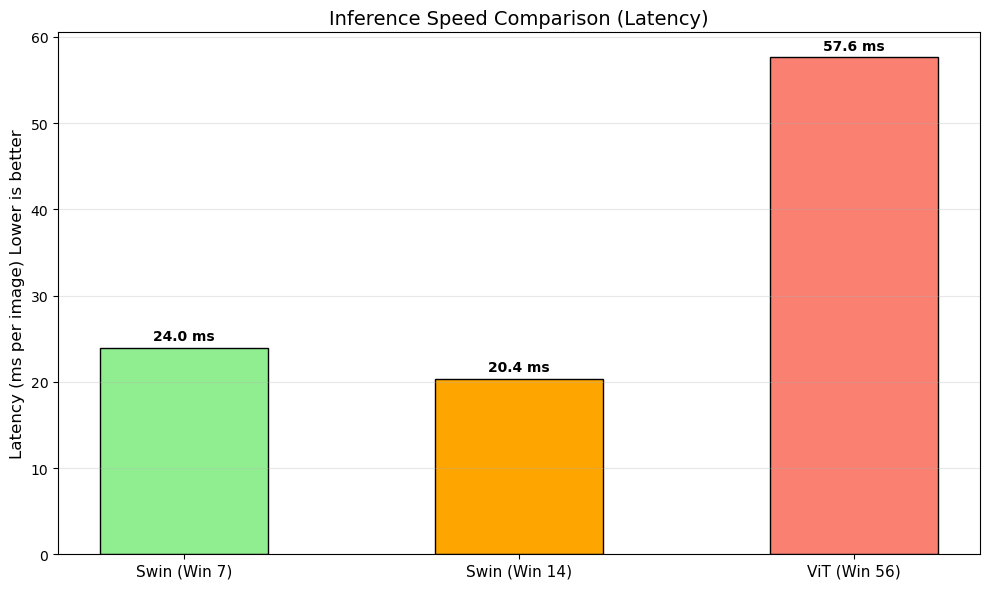

In [ ]:
sys.path.append(os.path.abspath('..'))

try:
    from config import get_config
    from models import build_model
except ImportError:
    print("Error: Could not import 'config' or 'models'. Make sure you are in the Swin-Transformer project root or correct the path.")

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print(f"Benchmark Hardware: {device}")

def measure_inference_speed(window_size, img_size=224, repetitions=100, batch_size=1):
    """
    Measures the inference speed of a model with a given window size.
    Args:
        window_size (int): The window size for the model.
        img_size (int): The input image size (assumed square).
        repetitions (int): Number of repetitions for averaging.
        batch_size (int): Batch size for inference.
    Returns:
        tuple: (frames per second, latency in milliseconds)
    """
    class Args:
        cfg = "../configs/swin/chest_xray_finetune.yaml"
        opts = [
            "DATA.IMG_SIZE", str(img_size),
            "MODEL.SWIN.WINDOW_SIZE", str(window_size),
            "MODEL.NUM_CLASSES", "2"
        ]
        batch_size = 1; data_path = ""; zip = False; cache_mode = "part"
        pretrained = ""; resume = ""; accumulation_steps = 1
        use_checkpoint = False; amp_opt_level = ""; output = "output"
        tag = "speed_test"; eval = True; throughput = False
        enable_amp = False; fused_window_process = False; fused_layernorm = False
        optim = "adamw"; local_rank = 0

    args = Args()
    if not os.path.exists(args.cfg): args.cfg = "configs/swin/chest_xray_finetune.yaml" # Fallback
    
    config = get_config(args)
    
    config.defrost()
    config.DATA.IMG_SIZE = img_size
    config.MODEL.SWIN.WINDOW_SIZE = window_size
    config.freeze()

    model = build_model(config).to(device)
    model.eval()

    input_tensor = torch.randn(batch_size, 3, img_size, img_size).to(device)

    print(f"Warmup {window_size}...")
    with torch.no_grad():
        for _ in range(10):
            _ = model(input_tensor)
            if device.type == 'mps': torch.mps.synchronize()

    print(f"Testing {window_size} ({repetitions} reps)...")
    timings = []
    
    with torch.no_grad():
        for _ in range(repetitions):
            if device.type == 'mps': torch.mps.synchronize()
            
            start = time.time()
            _ = model(input_tensor)
           
            if device.type == 'mps': torch.mps.synchronize()
            end = time.time()
            
            timings.append(end - start)

    avg_time = np.mean(timings)
    fps = 1 / avg_time
    latency_ms = avg_time * 1000
    
    del model
    return fps, latency_ms

models_config = [
    ("Swin (Win 7)", 7),
    ("Swin (Win 14)", 14),
    ("ViT (Win 56)", 56)
]

results_fps = []
results_ms = []
names = []

print("-" * 40)
for name, w_size in models_config:
    fps, ms = measure_inference_speed(w_size, img_size=224, repetitions=50)
    results_fps.append(fps)
    results_ms.append(ms)
    names.append(name)
    print(f"{name:<15} | {fps:.1f} FPS | {ms:.2f} ms")
print("-" * 40)

fig, ax1 = plt.subplots(figsize=(10, 6))

x = np.arange(len(names))
width = 0.5

rects = ax1.bar(x, results_ms, width, color=['lightgreen', 'orange', 'salmon'], edgecolor='black')

ax1.set_ylabel('Latency (ms per image) Lower is better', fontsize=12)
ax1.set_title('Inference Speed Comparison (Latency)', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(names, fontsize=11)
ax1.grid(True, axis='y', alpha=0.3)

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax1.annotate(f'{height:.1f} ms',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontweight='bold')

autolabel(rects)

plt.tight_layout()
plt.savefig("inference_speed_comparison.png")
plt.show()